Can we back into the same adversary prediction abilities using only the sorted edge weights? I.e. if we just look at the top n edges in the filtration, is this good enough? Or do we actually use persistent homology effectively?

In [1]:
import os
import parse
import pickle
import copy
import math

import torch
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
import dionysus as dion
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import svm
from sklearn.model_selection import cross_val_score
import sklearn
import networkx as nx
from grakel import GraphKernel
import grakel
import seaborn as sns

from pt_activation.models.ccff_fashion import CCFF

%load_ext autoreload
%autoreload 2

In [2]:
COLORS = ['#12355b', '#ff6978']
EDGE_COLOR = '#272d2d'
PLT_LABELS = ['Unaltered', 'Adversarial']

In [3]:
def get_adv_info(filename):
    format_string = 'true-{}_adv-{}_sample-{}.npy'
    parsed = parse.parse(format_string, filename)
    return {'true class':int(parsed[0]), 'adv class':int(parsed[1]), 'sample':int(parsed[2])}

def read_adversaries(loc):
    ret = []
    for f in os.listdir(loc):
        if os.path.isfile(os.path.join(loc,f)) and f.find('.npy') != -1:
            adv = np.load(os.path.join(loc, f))
            info = get_adv_info(f)
            info['adversary'] = adv
            ret.append(info)
    return ret
    

In [4]:
adv_directory_loc = '/home/tgebhart/projects/pt_activation/logdir/adversaries/fashion/lbfgsm/ccff_fashion.pt/90'
adversaries = read_adversaries(adv_directory_loc)
adversaries = sorted(adversaries,  key=lambda k: k['sample'])

In [5]:
def create_sample_graph(f):
    m = dion.homology_persistence(f)
    dgms = dion.init_diagrams(m,f)
    subgraphs = {}
    for i,c in enumerate(m):
        if len(c) == 2:
#                 print(" + ".join(["%d * %s" % (x.element, f[x.index]) for x in c]))
            if f[c[0].index][0] in subgraphs:
                subgraphs[f[c[0].index][0]].add_edge(f[c[0].index][0],f[c[1].index][0],weight=f[i].data)
            else:
                eaten = False
                for k, v in subgraphs.items():
                    if v.has_node(f[c[0].index][0]):
                        v.add_edge(f[c[0].index][0], f[c[1].index][0], weight=f[i].data)
                        eaten = True
                        break
                if not eaten:
                    g = nx.Graph()
                    g.add_edge(f[c[0].index][0], f[c[1].index][0], weight=f[i].data)
                    subgraphs[f[c[0].index][0]] = g

    return subgraphs, dgms[0]


def create_lifetimes(dgms):
    return [[pt.birth - pt.death for pt in dgm if pt.death < np.inf] for dgm in dgms]

In [6]:
def create_subgraphs(model, batch_size, up_to):
    device = torch.device("cpu")
    kwargs = {'num_workers': 1, 'pin_memory': True}
    test_loader = torch.utils.data.DataLoader(
        datasets.FashionMNIST('../../data/fashion', train=False, download=True, transform=transforms.Compose([
                           transforms.ToTensor(),
                       ])), batch_size=batch_size, shuffle=False, **kwargs)

    model.eval()
    test_loss = 0
    correct = 0
    t = 0
    res_df = []
    subgraphs = []
    diagrams = []
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output, hiddens = model(data, hiddens=True)
            test_loss = F.nll_loss(output, target).item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

            for s in range(data.shape[0]):
                this_hiddens = [hiddens[0][s], hiddens[1][s], hiddens[2][s]]
                print('Filtration: {}'.format(s+t))
                f = model.compute_dynamic_filtration(data[s], this_hiddens)
                sg, dg = create_sample_graph(f)
                row = {'loss':test_loss, 'class':target.cpu().numpy()[s], 'prediction':pred.cpu().numpy()[s][0]}
                res_df.append(row)
                subgraphs.append(sg)
                diagrams.append(dg)

            t += batch_size
            if t >= up_to:
                break

    return pd.DataFrame(res_df), subgraphs, diagrams


def create_adversary_subgraphs(model, batch_size, up_to, adversaries):
    device = torch.device("cpu")
    adv_images = torch.tensor(np.array([a['adversary'] for a in adversaries]))
    adv_labels = torch.tensor(np.array([a['true class'] for a in adversaries]))
    adv_samples = [a['sample'] for a in adversaries]
    
    print(adv_images.shape, adv_labels.shape)
    
    advs = torch.utils.data.TensorDataset(adv_images, adv_labels)
    test_loader = torch.utils.data.DataLoader(advs, batch_size=batch_size, shuffle=False)
    
    model.eval()
    test_loss = 0
    correct = 0
    t = 0
    res_df = []
    subgraphs = []
    diagrams = []
    with torch.no_grad():
        
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output, hiddens = model(data, hiddens=True)
            test_loss = F.nll_loss(output, target).item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
            for s in range(data.shape[0]):
                this_hiddens = [hiddens[0][s], hiddens[1][s], hiddens[2][s]]
                print('Filtration: {}'.format(s+t))
                f = model.compute_dynamic_filtration(data[s], this_hiddens)
                sg, dg = create_sample_graph(f)
                row = {'loss':test_loss, 'class':target.cpu().numpy()[s], 'prediction':pred.cpu().numpy()[s][0]}
                res_df.append(row)
                subgraphs.append(sg)
                diagrams.append(dg)

            t += (batch_size)
            if t >= up_to:
                break

    return pd.DataFrame(res_df), subgraphs, diagrams

In [7]:
model_location = '/home/tgebhart/projects/pt_activation/logdir/models/ccff_fashion.pt'
model = CCFF()
model.load_state_dict(torch.load(model_location))

In [8]:
res_df, sample_graphs, dgms = create_subgraphs(model, 1, 1000)

Filtration: 0
filtration size 242951
Sorting filtration...
Filtration: 1
filtration size 309409
Sorting filtration...
Filtration: 2
filtration size 213710
Sorting filtration...
Filtration: 3
filtration size 207946
Sorting filtration...
Filtration: 4
filtration size 322287
Sorting filtration...
Filtration: 5
filtration size 233009
Sorting filtration...
Filtration: 6
filtration size 284453
Sorting filtration...
Filtration: 7
filtration size 300818
Sorting filtration...
Filtration: 8
filtration size 144996
Sorting filtration...
Filtration: 9
filtration size 220706
Sorting filtration...
Filtration: 10
filtration size 308688
Sorting filtration...
Filtration: 11
filtration size 217022
Sorting filtration...
Filtration: 12
filtration size 234577
Sorting filtration...
Filtration: 13
filtration size 205285
Sorting filtration...
Filtration: 14
filtration size 331024
Sorting filtration...
Filtration: 15
filtration size 213228
Sorting filtration...
Filtration: 16
filtration size 324126
Sorting filt

filtration size 332038
Sorting filtration...
Filtration: 137
filtration size 195858
Sorting filtration...
Filtration: 138
filtration size 306449
Sorting filtration...
Filtration: 139
filtration size 215277
Sorting filtration...
Filtration: 140
filtration size 213437
Sorting filtration...
Filtration: 141
filtration size 319821
Sorting filtration...
Filtration: 142
filtration size 301262
Sorting filtration...
Filtration: 143
filtration size 313150
Sorting filtration...
Filtration: 144
filtration size 202689
Sorting filtration...
Filtration: 145
filtration size 339030
Sorting filtration...
Filtration: 146
filtration size 210920
Sorting filtration...
Filtration: 147
filtration size 232343
Sorting filtration...
Filtration: 148
filtration size 328793
Sorting filtration...
Filtration: 149
filtration size 325472
Sorting filtration...
Filtration: 150
filtration size 323505
Sorting filtration...
Filtration: 151
filtration size 329819
Sorting filtration...
Filtration: 152
filtration size 214486
S

Filtration: 271
filtration size 291952
Sorting filtration...
Filtration: 272
filtration size 313359
Sorting filtration...
Filtration: 273
filtration size 282508
Sorting filtration...
Filtration: 274
filtration size 233333
Sorting filtration...
Filtration: 275
filtration size 310804
Sorting filtration...
Filtration: 276
filtration size 304096
Sorting filtration...
Filtration: 277
filtration size 270148
Sorting filtration...
Filtration: 278
filtration size 199026
Sorting filtration...
Filtration: 279
filtration size 337975
Sorting filtration...
Filtration: 280
filtration size 296477
Sorting filtration...
Filtration: 281
filtration size 209058
Sorting filtration...
Filtration: 282
filtration size 336488
Sorting filtration...
Filtration: 283
filtration size 251606
Sorting filtration...
Filtration: 284
filtration size 309810
Sorting filtration...
Filtration: 285
filtration size 336714
Sorting filtration...
Filtration: 286
filtration size 344505
Sorting filtration...
Filtration: 287
filtrati

Filtration: 406
filtration size 289729
Sorting filtration...
Filtration: 407
filtration size 293751
Sorting filtration...
Filtration: 408
filtration size 317974
Sorting filtration...
Filtration: 409
filtration size 238863
Sorting filtration...
Filtration: 410
filtration size 314432
Sorting filtration...
Filtration: 411
filtration size 326884
Sorting filtration...
Filtration: 412
filtration size 218345
Sorting filtration...
Filtration: 413
filtration size 323770
Sorting filtration...
Filtration: 414
filtration size 261172
Sorting filtration...
Filtration: 415
filtration size 268901
Sorting filtration...
Filtration: 416
filtration size 322943
Sorting filtration...
Filtration: 417
filtration size 217998
Sorting filtration...
Filtration: 418
filtration size 287448
Sorting filtration...
Filtration: 419
filtration size 322887
Sorting filtration...
Filtration: 420
filtration size 166343
Sorting filtration...
Filtration: 421
filtration size 309742
Sorting filtration...
Filtration: 422
filtrati

Filtration: 541
filtration size 311863
Sorting filtration...
Filtration: 542
filtration size 265332
Sorting filtration...
Filtration: 543
filtration size 218377
Sorting filtration...
Filtration: 544
filtration size 289666
Sorting filtration...
Filtration: 545
filtration size 203408
Sorting filtration...
Filtration: 546
filtration size 318390
Sorting filtration...
Filtration: 547
filtration size 331542
Sorting filtration...
Filtration: 548
filtration size 336568
Sorting filtration...
Filtration: 549
filtration size 278047
Sorting filtration...
Filtration: 550
filtration size 312668
Sorting filtration...
Filtration: 551
filtration size 180203
Sorting filtration...
Filtration: 552
filtration size 178273
Sorting filtration...
Filtration: 553
filtration size 218487
Sorting filtration...
Filtration: 554
filtration size 163623
Sorting filtration...
Filtration: 555
filtration size 211920
Sorting filtration...
Filtration: 556
filtration size 265524
Sorting filtration...
Filtration: 557
filtrati

Filtration: 676
filtration size 241118
Sorting filtration...
Filtration: 677
filtration size 312168
Sorting filtration...
Filtration: 678
filtration size 264179
Sorting filtration...
Filtration: 679
filtration size 315364
Sorting filtration...
Filtration: 680
filtration size 265101
Sorting filtration...
Filtration: 681
filtration size 357947
Sorting filtration...
Filtration: 682
filtration size 339651
Sorting filtration...
Filtration: 683
filtration size 258564
Sorting filtration...
Filtration: 684
filtration size 278595
Sorting filtration...
Filtration: 685
filtration size 282644
Sorting filtration...
Filtration: 686
filtration size 326104
Sorting filtration...
Filtration: 687
filtration size 289614
Sorting filtration...
Filtration: 688
filtration size 300953
Sorting filtration...
Filtration: 689
filtration size 316722
Sorting filtration...
Filtration: 690
filtration size 255458
Sorting filtration...
Filtration: 691
filtration size 306620
Sorting filtration...
Filtration: 692
filtrati

Filtration: 811
filtration size 283375
Sorting filtration...
Filtration: 812
filtration size 198535
Sorting filtration...
Filtration: 813
filtration size 310315
Sorting filtration...
Filtration: 814
filtration size 218363
Sorting filtration...
Filtration: 815
filtration size 330394
Sorting filtration...
Filtration: 816
filtration size 250757
Sorting filtration...
Filtration: 817
filtration size 339141
Sorting filtration...
Filtration: 818
filtration size 353189
Sorting filtration...
Filtration: 819
filtration size 217279
Sorting filtration...
Filtration: 820
filtration size 265266
Sorting filtration...
Filtration: 821
filtration size 275597
Sorting filtration...
Filtration: 822
filtration size 265727
Sorting filtration...
Filtration: 823
filtration size 320939
Sorting filtration...
Filtration: 824
filtration size 257192
Sorting filtration...
Filtration: 825
filtration size 221984
Sorting filtration...
Filtration: 826
filtration size 261429
Sorting filtration...
Filtration: 827
filtrati

Filtration: 946
filtration size 170170
Sorting filtration...
Filtration: 947
filtration size 337770
Sorting filtration...
Filtration: 948
filtration size 271448
Sorting filtration...
Filtration: 949
filtration size 301933
Sorting filtration...
Filtration: 950
filtration size 222977
Sorting filtration...
Filtration: 951
filtration size 325719
Sorting filtration...
Filtration: 952
filtration size 251663
Sorting filtration...
Filtration: 953
filtration size 349340
Sorting filtration...
Filtration: 954
filtration size 330952
Sorting filtration...
Filtration: 955
filtration size 326667
Sorting filtration...
Filtration: 956
filtration size 353195
Sorting filtration...
Filtration: 957
filtration size 206498
Sorting filtration...
Filtration: 958
filtration size 270883
Sorting filtration...
Filtration: 959
filtration size 311683
Sorting filtration...
Filtration: 960
filtration size 295688
Sorting filtration...
Filtration: 961
filtration size 244282
Sorting filtration...
Filtration: 962
filtrati

In [9]:
adv_df, adv_sample_graphs, adv_dgms = create_adversary_subgraphs(model, 1, 1000, adversaries)

torch.Size([3000, 1, 28, 28]) torch.Size([3000])
Filtration: 0
filtration size 293341
Sorting filtration...
Filtration: 1
filtration size 316142
Sorting filtration...
Filtration: 2
filtration size 288516
Sorting filtration...
Filtration: 3
filtration size 285789
Sorting filtration...
Filtration: 4
filtration size 327441
Sorting filtration...
Filtration: 5
filtration size 283837
Sorting filtration...
Filtration: 6
filtration size 291791
Sorting filtration...
Filtration: 7
filtration size 302381
Sorting filtration...
Filtration: 8
filtration size 278377
Sorting filtration...
Filtration: 9
filtration size 292348
Sorting filtration...
Filtration: 10
filtration size 319502
Sorting filtration...
Filtration: 11
filtration size 282593
Sorting filtration...
Filtration: 12
filtration size 234577
Sorting filtration...
Filtration: 13
filtration size 296836
Sorting filtration...
Filtration: 14
filtration size 340996
Sorting filtration...
Filtration: 15
filtration size 287104
Sorting filtration...
F

Filtration: 136
filtration size 337636
Sorting filtration...
Filtration: 137
filtration size 279913
Sorting filtration...
Filtration: 138
filtration size 310548
Sorting filtration...
Filtration: 139
filtration size 280458
Sorting filtration...
Filtration: 140
filtration size 292322
Sorting filtration...
Filtration: 141
filtration size 329828
Sorting filtration...
Filtration: 142
filtration size 300352
Sorting filtration...
Filtration: 143
filtration size 337810
Sorting filtration...
Filtration: 144
filtration size 281728
Sorting filtration...
Filtration: 145
filtration size 353283
Sorting filtration...
Filtration: 146
filtration size 294391
Sorting filtration...
Filtration: 147
filtration size 232343
Sorting filtration...
Filtration: 148
filtration size 347492
Sorting filtration...
Filtration: 149
filtration size 331715
Sorting filtration...
Filtration: 150
filtration size 323505
Sorting filtration...
Filtration: 151
filtration size 325857
Sorting filtration...
Filtration: 152
filtrati

Filtration: 271
filtration size 294389
Sorting filtration...
Filtration: 272
filtration size 327466
Sorting filtration...
Filtration: 273
filtration size 295037
Sorting filtration...
Filtration: 274
filtration size 299240
Sorting filtration...
Filtration: 275
filtration size 326563
Sorting filtration...
Filtration: 276
filtration size 308913
Sorting filtration...
Filtration: 277
filtration size 302882
Sorting filtration...
Filtration: 278
filtration size 300927
Sorting filtration...
Filtration: 279
filtration size 343987
Sorting filtration...
Filtration: 280
filtration size 307445
Sorting filtration...
Filtration: 281
filtration size 292327
Sorting filtration...
Filtration: 282
filtration size 341181
Sorting filtration...
Filtration: 283
filtration size 306757
Sorting filtration...
Filtration: 284
filtration size 322300
Sorting filtration...
Filtration: 285
filtration size 336714
Sorting filtration...
Filtration: 286
filtration size 341046
Sorting filtration...
Filtration: 287
filtrati

Filtration: 406
filtration size 289729
Sorting filtration...
Filtration: 407
filtration size 326393
Sorting filtration...
Filtration: 408
filtration size 323630
Sorting filtration...
Filtration: 409
filtration size 238863
Sorting filtration...
Filtration: 410
filtration size 323144
Sorting filtration...
Filtration: 411
filtration size 328107
Sorting filtration...
Filtration: 412
filtration size 306778
Sorting filtration...
Filtration: 413
filtration size 323770
Sorting filtration...
Filtration: 414
filtration size 314907
Sorting filtration...
Filtration: 415
filtration size 296584
Sorting filtration...
Filtration: 416
filtration size 330980
Sorting filtration...
Filtration: 417
filtration size 296302
Sorting filtration...
Filtration: 418
filtration size 307089
Sorting filtration...
Filtration: 419
filtration size 324931
Sorting filtration...
Filtration: 420
filtration size 274401
Sorting filtration...
Filtration: 421
filtration size 321791
Sorting filtration...
Filtration: 422
filtrati

Filtration: 541
filtration size 319755
Sorting filtration...
Filtration: 542
filtration size 287360
Sorting filtration...
Filtration: 543
filtration size 286652
Sorting filtration...
Filtration: 544
filtration size 297017
Sorting filtration...
Filtration: 545
filtration size 289953
Sorting filtration...
Filtration: 546
filtration size 319906
Sorting filtration...
Filtration: 547
filtration size 343840
Sorting filtration...
Filtration: 548
filtration size 335706
Sorting filtration...
Filtration: 549
filtration size 317764
Sorting filtration...
Filtration: 550
filtration size 307953
Sorting filtration...
Filtration: 551
filtration size 287535
Sorting filtration...
Filtration: 552
filtration size 290125
Sorting filtration...
Filtration: 553
filtration size 301712
Sorting filtration...
Filtration: 554
filtration size 276555
Sorting filtration...
Filtration: 555
filtration size 293789
Sorting filtration...
Filtration: 556
filtration size 300954
Sorting filtration...
Filtration: 557
filtrati

Filtration: 676
filtration size 282195
Sorting filtration...
Filtration: 677
filtration size 320582
Sorting filtration...
Filtration: 678
filtration size 309659
Sorting filtration...
Filtration: 679
filtration size 325268
Sorting filtration...
Filtration: 680
filtration size 294028
Sorting filtration...
Filtration: 681
filtration size 357947
Sorting filtration...
Filtration: 682
filtration size 339385
Sorting filtration...
Filtration: 683
filtration size 308149
Sorting filtration...
Filtration: 684
filtration size 310130
Sorting filtration...
Filtration: 685
filtration size 282644
Sorting filtration...
Filtration: 686
filtration size 337356
Sorting filtration...
Filtration: 687
filtration size 321204
Sorting filtration...
Filtration: 688
filtration size 300953
Sorting filtration...
Filtration: 689
filtration size 324091
Sorting filtration...
Filtration: 690
filtration size 285988
Sorting filtration...
Filtration: 691
filtration size 327248
Sorting filtration...
Filtration: 692
filtrati

Filtration: 811
filtration size 312866
Sorting filtration...
Filtration: 812
filtration size 283654
Sorting filtration...
Filtration: 813
filtration size 324598
Sorting filtration...
Filtration: 814
filtration size 297581
Sorting filtration...
Filtration: 815
filtration size 340269
Sorting filtration...
Filtration: 816
filtration size 305017
Sorting filtration...
Filtration: 817
filtration size 341970
Sorting filtration...
Filtration: 818
filtration size 350510
Sorting filtration...
Filtration: 819
filtration size 293978
Sorting filtration...
Filtration: 820
filtration size 298635
Sorting filtration...
Filtration: 821
filtration size 297008
Sorting filtration...
Filtration: 822
filtration size 286441
Sorting filtration...
Filtration: 823
filtration size 320939
Sorting filtration...
Filtration: 824
filtration size 304125
Sorting filtration...
Filtration: 825
filtration size 282627
Sorting filtration...
Filtration: 826
filtration size 311532
Sorting filtration...
Filtration: 827
filtrati

Filtration: 946
filtration size 288578
Sorting filtration...
Filtration: 947
filtration size 324583
Sorting filtration...
Filtration: 948
filtration size 297384
Sorting filtration...
Filtration: 949
filtration size 310730
Sorting filtration...
Filtration: 950
filtration size 295178
Sorting filtration...
Filtration: 951
filtration size 329385
Sorting filtration...
Filtration: 952
filtration size 291335
Sorting filtration...
Filtration: 953
filtration size 351915
Sorting filtration...
Filtration: 954
filtration size 330525
Sorting filtration...
Filtration: 955
filtration size 328224
Sorting filtration...
Filtration: 956
filtration size 353195
Sorting filtration...
Filtration: 957
filtration size 296405
Sorting filtration...
Filtration: 958
filtration size 295505
Sorting filtration...
Filtration: 959
filtration size 326912
Sorting filtration...
Filtration: 960
filtration size 295688
Sorting filtration...
Filtration: 961
filtration size 286940
Sorting filtration...
Filtration: 962
filtrati

In [10]:
with open(os.path.join(adv_directory_loc, 'adv_samples.pkl'), 'wb') as f:
    pickle.dump(adv_sample_graphs, f)
with open(os.path.join(adv_directory_loc, 'samples.pkl'), 'wb') as f:
    pickle.dump(sample_graphs, f)

# sample_graphs = pickle.load( open(os.path.join(adv_directory_loc, 'samples.pkl'), "rb") )
# adv_sample_graphs = pickle.load( open(os.path.join(adv_directory_loc, 'adv_samples.pkl'), "rb") )

In [11]:
lifetimes = create_lifetimes(dgms)
adv_lifetimes = create_lifetimes(adv_dgms)

Text(0.5, 0, 'Mean Lifetime')

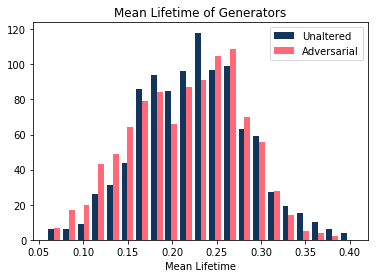

In [12]:
mls = [np.mean(l) for l in lifetimes]
adv_mls = [np.mean(l) for l in adv_lifetimes]
plt.hist([mls, adv_mls], bins='auto', color=COLORS, label=PLT_LABELS)
plt.legend()
plt.title('Mean Lifetime of Generators')
plt.xlabel('Mean Lifetime')

Text(0.5, 0, 'Median Lifetime')

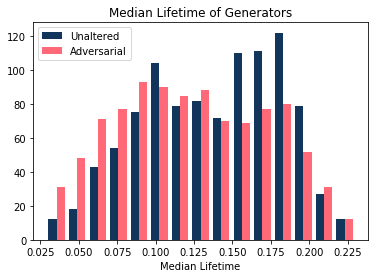

In [13]:
mls = [np.median(l) for l in lifetimes]
adv_mls = [np.median(l) for l in adv_lifetimes]
plt.hist([mls, adv_mls], bins='auto', color=COLORS, label=PLT_LABELS)
plt.legend()
plt.title('Median Lifetime of Generators')
plt.xlabel('Median Lifetime')

In [14]:
# for dgm in dgms:
#     dion.plot.plot_diagram(dgm, show=True)

In [15]:
# for adv_dgm in adv_dgms:
#     dion.plot.plot_diagram(adv_dgm, show=True)

In [16]:
# thru = 3
# all_gois = []
# for i in range(len(sample_graphs)):
#     print(i)
#     ks = list(sample_graphs[i].keys())
#     a = [sample_graphs[i][k] for k in ks[:thru]]
#     all_gois.append(nx.compose_all(a))
    
# adv_all_gois = []
# for i in range(len(adv_sample_graphs)):
#     print(i)
#     ks = list(adv_sample_graphs[i].keys())
#     a = [adv_sample_graphs[i][k] for k in ks[:thru]]
#     adv_all_gois.append(nx.compose_all(a))

In [17]:
kernel = 'linear'
take = 15
edges = set()
for i in range(len(sample_graphs)):
    for k in list(sample_graphs[i].keys())[:take]:
        for x in sample_graphs[i][k].edges(data=True):
            edge_name = str(x[0])+'-'+str(x[1])
            edges.add(edge_name)

In [18]:
edf = pd.DataFrame(np.zeros((len(sample_graphs),len(edges))), columns=list(edges))
for i in range(len(sample_graphs)):
    print('Sample: {}/{}'.format(i,len(sample_graphs)))
    lst = list(sample_graphs[i].keys())
    for k in lst[:take]:
        for x in sample_graphs[i][k].edges(data=True):
            edge_name = str(x[0])+'-'+str(x[1])
            edf.iloc[i][edge_name] += 1

Sample: 0/1000
Sample: 1/1000
Sample: 2/1000
Sample: 3/1000
Sample: 4/1000
Sample: 5/1000
Sample: 6/1000
Sample: 7/1000
Sample: 8/1000
Sample: 9/1000
Sample: 10/1000
Sample: 11/1000
Sample: 12/1000
Sample: 13/1000
Sample: 14/1000
Sample: 15/1000
Sample: 16/1000
Sample: 17/1000
Sample: 18/1000
Sample: 19/1000
Sample: 20/1000
Sample: 21/1000
Sample: 22/1000
Sample: 23/1000
Sample: 24/1000
Sample: 25/1000
Sample: 26/1000
Sample: 27/1000
Sample: 28/1000
Sample: 29/1000
Sample: 30/1000
Sample: 31/1000
Sample: 32/1000
Sample: 33/1000
Sample: 34/1000
Sample: 35/1000
Sample: 36/1000
Sample: 37/1000
Sample: 38/1000
Sample: 39/1000
Sample: 40/1000
Sample: 41/1000
Sample: 42/1000
Sample: 43/1000
Sample: 44/1000
Sample: 45/1000
Sample: 46/1000
Sample: 47/1000
Sample: 48/1000
Sample: 49/1000
Sample: 50/1000
Sample: 51/1000
Sample: 52/1000
Sample: 53/1000
Sample: 54/1000
Sample: 55/1000
Sample: 56/1000
Sample: 57/1000
Sample: 58/1000
Sample: 59/1000
Sample: 60/1000
Sample: 61/1000
Sample: 62/1000
Sa

Sample: 495/1000
Sample: 496/1000
Sample: 497/1000
Sample: 498/1000
Sample: 499/1000
Sample: 500/1000
Sample: 501/1000
Sample: 502/1000
Sample: 503/1000
Sample: 504/1000
Sample: 505/1000
Sample: 506/1000
Sample: 507/1000
Sample: 508/1000
Sample: 509/1000
Sample: 510/1000
Sample: 511/1000
Sample: 512/1000
Sample: 513/1000
Sample: 514/1000
Sample: 515/1000
Sample: 516/1000
Sample: 517/1000
Sample: 518/1000
Sample: 519/1000
Sample: 520/1000
Sample: 521/1000
Sample: 522/1000
Sample: 523/1000
Sample: 524/1000
Sample: 525/1000
Sample: 526/1000
Sample: 527/1000
Sample: 528/1000
Sample: 529/1000
Sample: 530/1000
Sample: 531/1000
Sample: 532/1000
Sample: 533/1000
Sample: 534/1000
Sample: 535/1000
Sample: 536/1000
Sample: 537/1000
Sample: 538/1000
Sample: 539/1000
Sample: 540/1000
Sample: 541/1000
Sample: 542/1000
Sample: 543/1000
Sample: 544/1000
Sample: 545/1000
Sample: 546/1000
Sample: 547/1000
Sample: 548/1000
Sample: 549/1000
Sample: 550/1000
Sample: 551/1000
Sample: 552/1000
Sample: 553/10

Sample: 979/1000
Sample: 980/1000
Sample: 981/1000
Sample: 982/1000
Sample: 983/1000
Sample: 984/1000
Sample: 985/1000
Sample: 986/1000
Sample: 987/1000
Sample: 988/1000
Sample: 989/1000
Sample: 990/1000
Sample: 991/1000
Sample: 992/1000
Sample: 993/1000
Sample: 994/1000
Sample: 995/1000
Sample: 996/1000
Sample: 997/1000
Sample: 998/1000
Sample: 999/1000


In [19]:
edf.head()

,554-1236,2045-6440,1859-4885,2293-6669,3300-4036,263-938,1729-430,2382-6310,1645-1867,2455-6839,...,1818-4338,2243-6183,2150-5568,492-2310,240-989,1880-1784,1707-4766,5297-1758,1076-2736,133-1956
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [20]:
X = edf.values
y = res_df['class'].values

In [21]:
clf = svm.SVC( decision_function_shape='ovo', kernel=kernel)
cross_val_score(clf, X, y, cv=10)

array([0.67619048, 0.71153846, 0.72115385, 0.69902913, 0.65048544,
       0.68367347, 0.7244898 , 0.71578947, 0.69473684, 0.71578947])

In [22]:
print('Natural performance: ', res_df[res_df['class'] == res_df['prediction']].shape[0]/res_df.shape[0])

Natural performance:  0.895


In [23]:
t_fit = svm.SVC(decision_function_shape='ovo', kernel=kernel).fit(X,y)

In [24]:
# take = 3
# adv_edges = set()
# for i in range(len(adv_sample_graphs)):
#     for k in list(adv_sample_graphs[i].keys())[:take]:
#         for x in adv_sample_graphs[i][k].edges(data=True):
#             edge_name = str(x[0])+'-'+str(x[1])
#             adv_edges.add(edge_name)

In [25]:
adv_edf = pd.DataFrame(np.zeros((len(adv_sample_graphs),len(edges))), columns=list(edges))
for i in range(len(adv_sample_graphs)):
    print('Sample: {}/{}'.format(i,len(adv_sample_graphs)))
    lst = list(adv_sample_graphs[i].keys())
    for k in lst[:take]:
        for x in adv_sample_graphs[i][k].edges(data=True):
            edge_name = str(x[0])+'-'+str(x[1])
            if edge_name in adv_edf.columns:
                adv_edf.iloc[i][edge_name] += 1

Sample: 0/1000
Sample: 1/1000
Sample: 2/1000
Sample: 3/1000
Sample: 4/1000
Sample: 5/1000
Sample: 6/1000
Sample: 7/1000
Sample: 8/1000
Sample: 9/1000
Sample: 10/1000
Sample: 11/1000
Sample: 12/1000
Sample: 13/1000
Sample: 14/1000
Sample: 15/1000
Sample: 16/1000
Sample: 17/1000
Sample: 18/1000
Sample: 19/1000
Sample: 20/1000
Sample: 21/1000
Sample: 22/1000
Sample: 23/1000
Sample: 24/1000
Sample: 25/1000
Sample: 26/1000
Sample: 27/1000
Sample: 28/1000
Sample: 29/1000
Sample: 30/1000
Sample: 31/1000
Sample: 32/1000
Sample: 33/1000
Sample: 34/1000
Sample: 35/1000
Sample: 36/1000
Sample: 37/1000
Sample: 38/1000
Sample: 39/1000
Sample: 40/1000
Sample: 41/1000
Sample: 42/1000
Sample: 43/1000
Sample: 44/1000
Sample: 45/1000
Sample: 46/1000
Sample: 47/1000
Sample: 48/1000
Sample: 49/1000
Sample: 50/1000
Sample: 51/1000
Sample: 52/1000
Sample: 53/1000
Sample: 54/1000
Sample: 55/1000
Sample: 56/1000
Sample: 57/1000
Sample: 58/1000
Sample: 59/1000
Sample: 60/1000
Sample: 61/1000
Sample: 62/1000
Sa

Sample: 490/1000
Sample: 491/1000
Sample: 492/1000
Sample: 493/1000
Sample: 494/1000
Sample: 495/1000
Sample: 496/1000
Sample: 497/1000
Sample: 498/1000
Sample: 499/1000
Sample: 500/1000
Sample: 501/1000
Sample: 502/1000
Sample: 503/1000
Sample: 504/1000
Sample: 505/1000
Sample: 506/1000
Sample: 507/1000
Sample: 508/1000
Sample: 509/1000
Sample: 510/1000
Sample: 511/1000
Sample: 512/1000
Sample: 513/1000
Sample: 514/1000
Sample: 515/1000
Sample: 516/1000
Sample: 517/1000
Sample: 518/1000
Sample: 519/1000
Sample: 520/1000
Sample: 521/1000
Sample: 522/1000
Sample: 523/1000
Sample: 524/1000
Sample: 525/1000
Sample: 526/1000
Sample: 527/1000
Sample: 528/1000
Sample: 529/1000
Sample: 530/1000
Sample: 531/1000
Sample: 532/1000
Sample: 533/1000
Sample: 534/1000
Sample: 535/1000
Sample: 536/1000
Sample: 537/1000
Sample: 538/1000
Sample: 539/1000
Sample: 540/1000
Sample: 541/1000
Sample: 542/1000
Sample: 543/1000
Sample: 544/1000
Sample: 545/1000
Sample: 546/1000
Sample: 547/1000
Sample: 548/10

Sample: 972/1000
Sample: 973/1000
Sample: 974/1000
Sample: 975/1000
Sample: 976/1000
Sample: 977/1000
Sample: 978/1000
Sample: 979/1000
Sample: 980/1000
Sample: 981/1000
Sample: 982/1000
Sample: 983/1000
Sample: 984/1000
Sample: 985/1000
Sample: 986/1000
Sample: 987/1000
Sample: 988/1000
Sample: 989/1000
Sample: 990/1000
Sample: 991/1000
Sample: 992/1000
Sample: 993/1000
Sample: 994/1000
Sample: 995/1000
Sample: 996/1000
Sample: 997/1000
Sample: 998/1000
Sample: 999/1000


In [26]:
adv_preds = t_fit.predict(adv_edf.values)

In [27]:
adv_preds[:5]

array([9, 2, 1, 1, 6])

In [28]:
adv_df.head(20)

,class,loss,prediction
0,9,-11.485815,7
1,2,-12.727735,4
2,1,-14.787285,3
3,1,-13.633474,3
4,6,-11.390934,0
5,1,-12.762306,0
6,4,-10.610786,6
7,6,-11.641573,4
8,5,-3.054615,7
9,7,-7.763920,5


In [29]:
adv_df['class'].iloc[:adv_preds.shape[0]].shape

(1000,)

In [30]:
adv_preds.shape

(1000,)

In [31]:
print('Recovery Accuracy: {}'.format(adv_df[adv_df['class'] == adv_preds].shape[0]/adv_df.shape[0]))

Recovery Accuracy: 0.896


In [32]:
print('Adversary Class Percentage: {}'.format(adv_df[adv_df['prediction'] == adv_preds].shape[0]/adv_df.shape[0]))

Adversary Class Percentage: 0.059


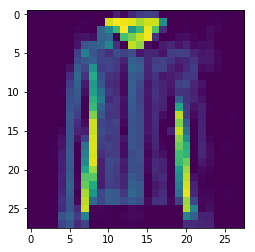

In [45]:
plt.imshow(adversaries[6]['adversary'].reshape(28,28))

In [34]:
adv_df['prediction'].value_counts()/adv_df.shape[0]

6    0.221
7    0.147
3    0.127
4    0.106
0    0.106
2    0.104
5    0.071
9    0.063
8    0.033
1    0.022
Name: prediction, dtype: float64

In [35]:
adv_df[adv_df['class'] == adv_preds]['prediction'].value_counts()/adv_df[adv_df['class'] == adv_preds]['prediction'].shape[0]

6    0.218750
7    0.154018
3    0.129464
2    0.104911
4    0.102679
0    0.100446
5    0.073661
9    0.060268
8    0.032366
1    0.023438
Name: prediction, dtype: float64

In [47]:
colors = ['black', 'blue', 'red', 'green', 'yellow', 'orange', 'purple', 'pink', 'silver', 'cyan']
labels = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [37]:
# from sklearn.decomposition import PCA
# from mpl_toolkits.mplot3d import Axes3D
# import PyQt5

# fig = plt.figure(1, figsize=(4, 3))
# plt.clf()
# ax = Axes3D(fig)

# plt.cla()
# pca = PCA(n_components=3)
# pca.fit(X)
# X_pca = pca.transform(X)

# for i in range(len(X_pca)):
#     ax.scatter(X_pca[i,0], X_pca[i,1], X_pca[i,2], color=colors[res_df['prediction'].iloc[i]])

In [38]:
# from sklearn import manifold
# from collections import OrderedDict

# fig = plt.figure(1, figsize=(4, 3))
# plt.clf()
# ax = Axes3D(fig)
# plt.cla()

# # X_dimmed = manifold.TSNE(n_components=3, init='pca', random_state=0).fit_transform(X)
# X_dimmed = manifold.Isomap(10, 3).fit_transform(X)

# for i in range(len(X_dimmed)):
#     ax.scatter(X_dimmed[i,0], X_dimmed[i,1], X_dimmed[i,2], color=colors[res_df['class'].iloc[i]], label=labels[res_df['class'].iloc[i]])

# handles, labs = plt.gca().get_legend_handles_labels()
# by_label = OrderedDict(zip(labs, handles))
# ax.legend(by_label.values(), by_label.keys())

In [39]:
from sklearn.decomposition import PCA
from sklearn import manifold
from collections import OrderedDict

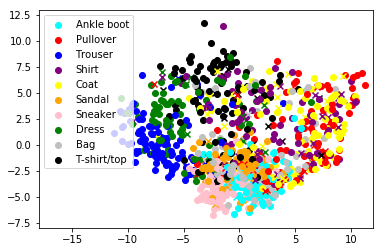

In [55]:
fig, ax = plt.subplots()
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

for i in range(len(X_pca)):
    mark = "o" if res_df.iloc[i]['prediction'] == res_df.iloc[i]['class'] else "x"
    ax.scatter(X_pca[i,0], X_pca[i,1], color=colors[res_df['class'].iloc[i]], label=labels[res_df['class'].iloc[i]], marker=mark)
handles, labs = plt.gca().get_legend_handles_labels()
ax.set_xlim(-18,12)
by_label = OrderedDict(zip(labs, handles))
ax.legend(by_label.values(), by_label.keys())

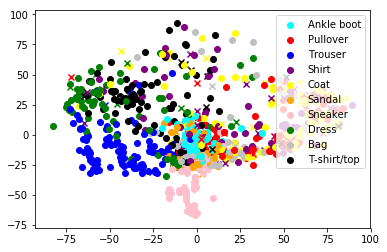

In [50]:
from sklearn import manifold
fig, ax = plt.subplots()
X_dimmed = manifold.Isomap(n_neighbors=5, n_components=2).fit_transform(X)
# X_dimmed = manifold.TSNE(n_components=2, init='pca', random_state=5).fit_transform(X)
# X_dimmed = manifold.SpectralEmbedding(n_neighbors=100, n_components=2).fit_transform(X)
# X_dimmed = manifold.MDS(2, max_iter=200, n_init=10).fit_transform(X)
# X_dimmed = manifold.LocallyLinearEmbedding(10, 2, eigen_solver='auto', method='standard').fit_transform(X)


for i in range(len(X_dimmed)):
    mark = "o" if res_df.iloc[i]['prediction'] == res_df.iloc[i]['class'] else "x"
    ax.scatter(X_dimmed[i,0], X_dimmed[i,1], color=colors[res_df['class'].iloc[i]], label=labels[res_df['class'].iloc[i]], marker=mark)
handles, labs = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labs, handles))
ax.legend(by_label.values(), by_label.keys())